#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 46.3 MB/s 
     |████████████████████████████████| 125 kB 68.0 MB/s 
     |████████████████████████████████| 512 kB 74.2 MB/s 


Скачаем данные

In [2]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 18 18:39 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


In [3]:
!pip install wandb
import wandb

wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 27.0 MB/s 
     |████████████████████████████████| 173 kB 68.2 MB/s 
     |████████████████████████████████| 182 kB 72.9 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 168 kB 72.4 MB/s 
     |████████████████████████████████| 168 kB 76.1 MB/s 
     |████████████████████████████████| 166 kB 75.7 MB/s 
     |████████████████████████████████| 166 kB 74.8 MB/s 
     |████████████████████████████████| 162 kB 60.5 MB/s 
     |████████████████████████████████| 162 kB 79.4 MB/s 
     |████████████████████████████████| 158 kB 60.1 MB/s 
     |████████████████████████████████| 157 kB 83.2 MB/s 
     |████████████████████████████████| 157 kB 83.1 MB/s 
     |████████████████████████████████| 157 kB 81.4 MB/s 
     |████████████████████████████████| 157 kB 83.4 MB/s 
     |███████████████████████████

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Посмотрим как выглядит один из файлов разметки

In [4]:
!cat data/train/apple_1.xml

<annotation>
	<folder>train</folder>
	<filename>apple_1.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>0</width>
		<height>0</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>15</ymin>
			<xmax>331</xmax>
			<ymax>349</ymax>
		</bndbox>
	</object>
</annotation>


## Релизуйте выборку для YoloV1 - 2 балла

In [5]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict
import warnings

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
import collections
from collections import Counter
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

warnings.filterwarnings("ignore")

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

В этой домашке я опирался на это видео: https://youtu.be/n9_XyCGr-MI и, соответственно, гит хаб репозиторий: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO

In [6]:
class2tag = {"apple": 0, "orange": 1, "banana": 2}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))  ## YOUR CODE
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml"))) ## YOUR CODE

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

        self.S=7
        self.B=2
        self.C=3

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])

        if self.transforms:
          transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
          image = transformed['image']
          boxes = transformed['bboxes']
          class_labels = transformed['class_labels']

          image = torchvision.transforms.functional.to_tensor(image)
        ## YOUR CODE
        for i in range(len(boxes)):
          boxes[i] = list(boxes[i])
          boxes[i].append(class_labels[i])

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        for box in boxes:
            x, y, width, height, class_label = box
            class_label = int(class_label)

            # i,j - координаты сетки (которфя 7*7)
            i, j = int(self.S * y), int(self.S * x)

            #Переводим координаты x, y, w, h в координаты относительно отдельной клетки

            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # Если в клетке еще нет объекта, то мы его туда записываем
            # Это значит, что в каждой клетке может быть только один объект!
            # В противном случае Yolov1 работает плохо (не увидит объекта), нужно повышать число клеток в сетке (т.е. увеличивать S)
            if label_matrix[i, j, 3] == 0:
                # Матрица 7*7*13 выглядит слудующим образом: i, j - координты клетки;
                # у каждой клетки 13 параметров: первые 3 - one-hot encoding для классов, потом 2 бокса по 5 координат - уверенность, что в боксе что-то есть и 4 координаты самого бокса
                # В случае таргета уверенность первого бокса будет равна 1, а 2ой бокс будет заполнен нулями
            
                label_matrix[i, j, 3] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                label_matrix[i, j, class_label] = 1

        return image, label_matrix

       

        return image, (boxes, class_labels)

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
      # """
      # Метод, который считает и распарсит (с помощью xmltodict) переданный xml
      # файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
      # и название класса обьекта в каждом прямоугольнике

      # Обратите внимание, что обьектов может быть как несколько, так и один единственный
      # """
        boxes = []
        class_labels = []

        ## YOUR CODE
        
        jpg_filename = xml_filename[:-3] + 'jpg'
        
        with open(xml_filename) as fd:
          doc = xmltodict.parse(fd.read())

        im = Image.open(jpg_filename)
        im_w, im_h = im.size

        if not isinstance(doc['annotation']['object'], list):
          doc['annotation']['object'] = [doc['annotation']['object']]
        
        for box in doc['annotation']['object']:
          list_coord = [int(coord) for key, coord in box['bndbox'].items()]
          list_coord = self.__convert_to_yolo_box_params(list_coord, im_w, im_h)

          name_tag = class2tag[box['name']]

          boxes.append(list_coord)
          class_labels.append(name_tag)

        ## YOUR CODE

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
      # """
      # Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
      
      # Обратите внимание, что параметры [x_center, y_center, width, height] - это
      # относительные значение в отрезке [0, 1]

      # :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
      # :param: im_w - ширина исходного изображения
      # :param: im_h - высота исходного изображения

      # :return: координаты коробки в формате [x_center, y_center, width, height]
      # """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans

In [7]:
#WIDTH, HEIGHT = 448

train_transform = A.Compose([A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5)], ## YOUR CODE
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5)], ## YOUR CODE
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [8]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

In [9]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True
    )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [10]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    # Это функция считает IoU для тензоров, а не просто координат; так удобнее
  
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) на случай, если не пересекутся
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.

В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера __S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

In [11]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        ## YOUR CODE
        # Сетка будет чем-то похожа на облегченную версию Yolo
        cnn_1 = CNNBlock(kernel_size=7, in_channels=3, out_channels=192, padding=3, is_max_pool=True, stride=2)
        cnn_2 = CNNBlock(kernel_size=3, in_channels=192, out_channels=256, padding=1, is_max_pool=True)
        cnn_3 = CNNBlock(kernel_size=1, in_channels=256, out_channels=512, padding=0, is_max_pool=False)
        cnn_4 = CNNBlock(kernel_size=3, in_channels=512, out_channels=512, padding=1, is_max_pool=False)
        cnn_5 = CNNBlock(kernel_size=3, in_channels=512, out_channels=1024, padding=1, is_max_pool=True)
        cnn_6 = CNNBlock(kernel_size=1, in_channels=1024, out_channels=1024, padding=0, is_max_pool=False)
        cnn_7 = CNNBlock(kernel_size=3, in_channels=1024, out_channels=1024, padding=1, is_max_pool=False)
        cnn_8 = CNNBlock(kernel_size=3, in_channels=1024, out_channels=1024, padding=1, is_max_pool=True)
        cnn_9 = CNNBlock(kernel_size=3, in_channels=1024, out_channels=1024, padding=1, is_max_pool=True)


        self.yolo = nn.Sequential(
            cnn_1,
            cnn_2,
            cnn_3,
            cnn_4,
            cnn_5,
            cnn_6,
            cnn_7,
            cnn_8,
            cnn_9,
            nn.Flatten(),
            nn.Linear(7*7*1024, 4096),
            nn.Linear(4096, 7*7*(10 + 3))
        )
        ## YOUR CODE

    def forward(self, x):
        
        ## YOUR CODE
        x = self.yolo(x)
        x = x.view(-1, self.S, self.S, 5 * self.B + self.C)
        return x


temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(train_dataset[0][0].unsqueeze(0)).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

In [12]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        ## YOUR CODE
      
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Считаем IoU для двух предсказанных боксов
        iou_b1 = intersection_over_union(predictions[..., 4:8], target[..., 4:8])
        iou_b2 = intersection_over_union(predictions[..., 9:13], target[..., 4:8])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Выбираем лучший бокс; bestbox это 0 или 1
        # exists_box: в статье это Iobj_i
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 3].unsqueeze(3)


        # Дальше лосс как в статье
        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 9:13]
                + (1 - bestbox) * predictions[..., 4:8]
            )
        )

        box_targets = exists_box * target[..., 4:8]

       
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        pred_box = (
            bestbox * predictions[..., 8:9] + (1 - bestbox) * predictions[..., 3:4]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 3:4]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 3:4], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 3:4], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 8:9], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 3:4], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :3], end_dim=-2,),
            torch.flatten(exists_box * target[..., :3], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # первые две строки в статье (там шде формула с лоссом)
            + object_loss  # третья строка
            + self.lambda_noobj * no_object_loss  # четвертая строка
            + class_loss  # пятая строка
        )

        return loss

## Реализуйте дополнительные функции из статьи - 2 балла

In [13]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=3
):
   # Считает mAP: предсказание считается TP, если пересечение с таргетом > iou_threshold

    average_precisions = []

    epsilon = 1e-6 #Чтобы на 0 не поделить

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

       
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
      
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [14]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint"):
    # Считает nms от боксов: сначала оставляем только боксы с уверенностью > threshold, потом оставляем только боксы, у которых пересечение с лучшим < iou_threshold

    assert type(bboxes) == list


    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def get_bound_boxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):

    # Достает боксы из модели и val_dataloader'а в адекватной форме и делает non-max supression с iou_threshold и threshold
    all_pred_boxes = []
    all_true_boxes = []

    model.cuda()
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
              
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    # Переводит координаты боксов относительно клеток в координаты относительно всего изображения

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 13)
    bboxes1 = predictions[..., 4:8]
    bboxes2 = predictions[..., 9:13]
    scores = torch.cat(
        (predictions[..., 3].unsqueeze(0), predictions[..., 8].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :3].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 3], predictions[..., 8]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [15]:
class YOLOLearner(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = YOLO()
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        # Первые 400-500 эпох были без ReduceLROnPlateau, с обычным адамом
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=10)
        return {'optimizer': self.optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        ## YOUR CODE
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        ## YOUR CODE
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("val_loss", loss, prog_bar=True)

In [16]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min')

In [17]:
import random

def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(123)

# Модель очень долго обучалась, 400-500 эпох с обычным адамом и еще 100-200 эпох с ReduceLROnPlateau. Все это в несколько заходов

n_epochs = 500

wandb_logger = WandbLogger(project="HW_3", log_model='all')

#yolo_learner = YOLOLearner()  ## YOUR CODE

device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs, logger=wandb_logger, callbacks=[checkpoint_callback])

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 245 M 
1 | loss  | YoloLoss | 0     
-----------------------------------
245 M     Trainable params
0         Non-trainable params
245 M     Total params
980.777   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [18]:
# Загружает не быстро, надо чуть-чуть подождать

run = wandb.init()
artifact = run.use_artifact('kirill_zernikov/HW_3/model-3sd1a9qr:v10', type='model')
artifact_dir = artifact.download()
run.join()

yolo_learner = YOLOLearner.load_from_checkpoint(artifact_dir + '/model.ckpt')

wandb: Currently logged in as: kirill_zernikov. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-3sd1a9qr:v10, 2806.13MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:2:24.1
wandb: WARNING wandb.run.join() is deprecated, please use wandb.run.finish().


## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [40]:
## YOUR CODE
# Почему-то лучшие результаты получаются при iou_threshold=0.26, threshold=0 в первой функции и iou_threshold=0 во второй функции
# Не знаю, с чем это может быть связано; мб функции написаны неправильно, но я ошибки не вижу
# Хотя сами результаты вроде неплохие, в оригинальной статье mAP у Fast Yolo (которая только с 9 сверточными слоями, как у меня) хуже, но тут мало классов, так что качество должно быть выше?
# С числами из статьи (0.5, 0.4, 0.5) получается 0.275 (27.5%)
seed_everything(123)

device="cuda:0"

pred_boxes, target_boxes = get_bound_boxes(
            val_dataloader, yolo_learner, iou_threshold=0.26, threshold=0, box_format='midpoint'
        )

mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0
)
print(f"Val mAP: {mean_avg_prec}")

Val mAP: 0.6840351223945618


## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

Я нарисую 20 картиночек

In [31]:
seed_everything(123)

images_test = [val_dataset[i][0].unsqueeze(0).to(device) for i in range(20)]

results = [yolo_learner(images_test[i]) for i in range(20)]

In [32]:
converted = [cellboxes_to_boxes(results[i]) for i in range(20)]

In [36]:
boxes_after_nms = [non_max_suppression(converted[i][0], 0.5, 0.1) for i in range(20)]

In [25]:
converted_targets = [cellboxes_to_boxes(val_dataset[i][1].unsqueeze(0)) for i in range(20)]

In [26]:
targets_after_nms = [non_max_suppression(converted_targets[i][0], 0.5, 0.1) for i in range(20)]

In [37]:
import matplotlib.patches as patches

In [38]:
def plot_image(image, boxes):
    # Рисуем картиночки
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]

        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

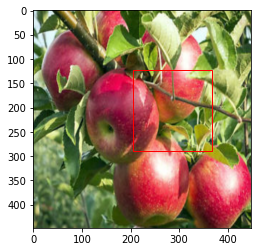

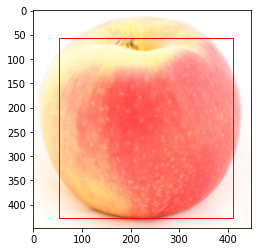

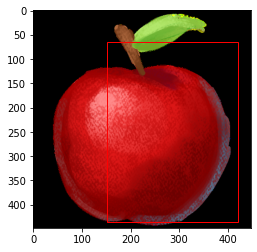

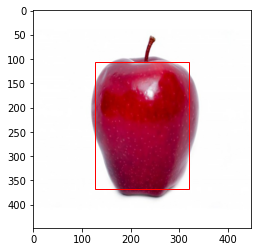

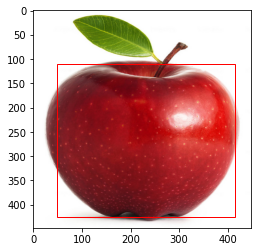

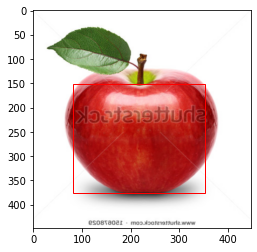

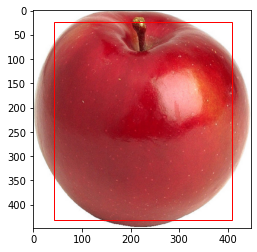

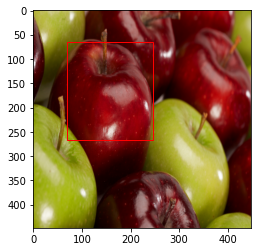

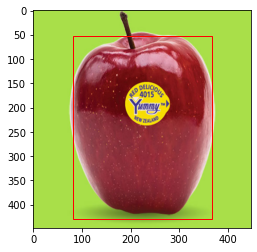

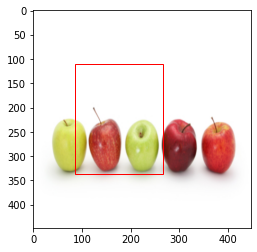

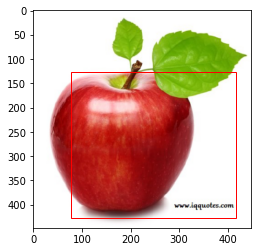

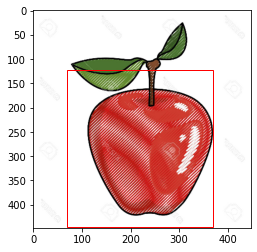

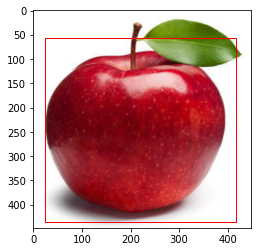

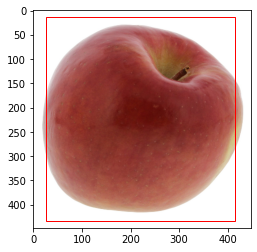

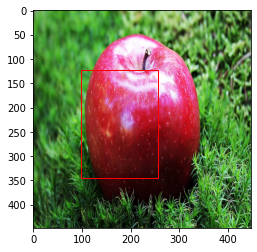

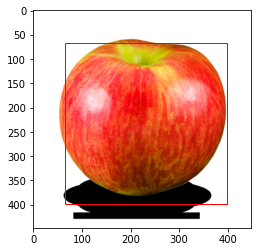

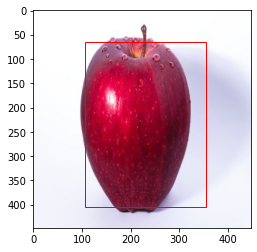

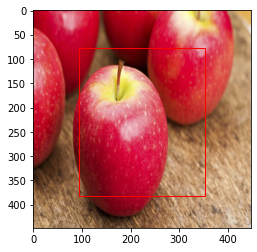

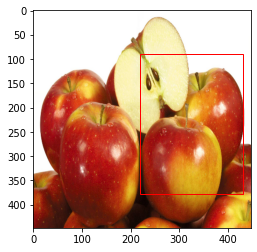

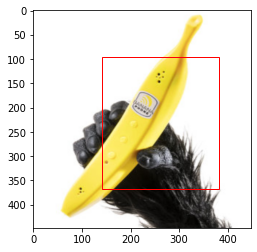

In [39]:
for i in range(20):
  plot_image(val_dataset[i][0].permute(1, 2, 0), [boxes_after_nms[i][0]])

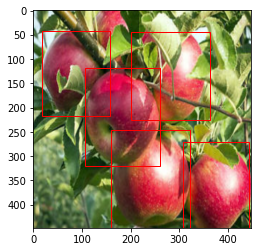

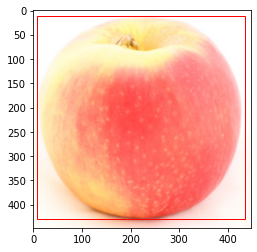

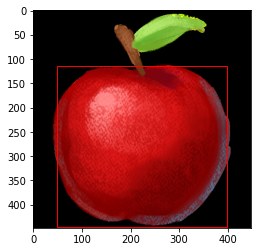

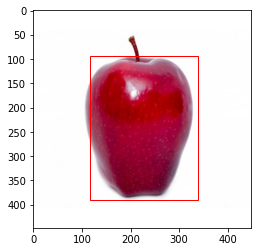

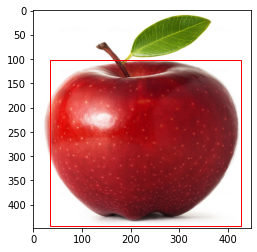

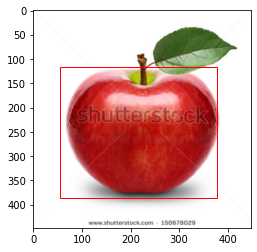

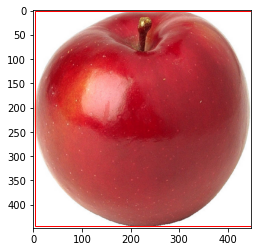

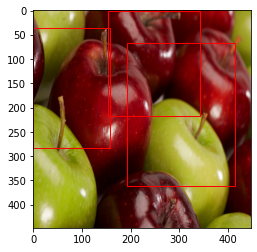

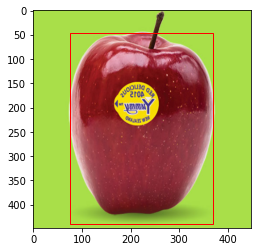

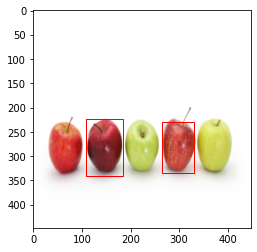

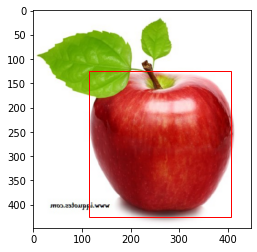

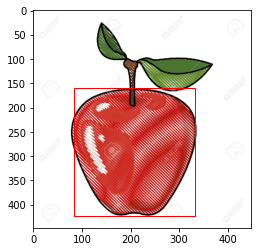

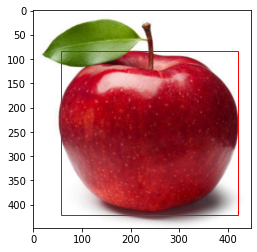

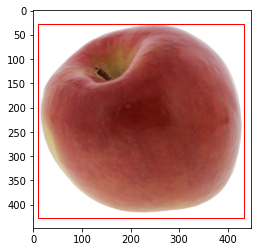

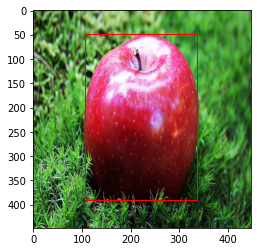

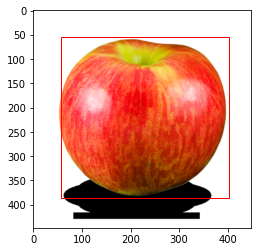

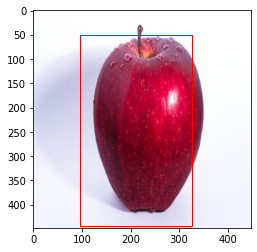

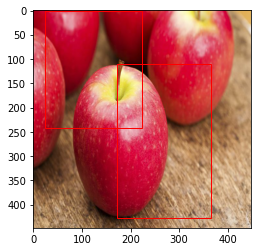

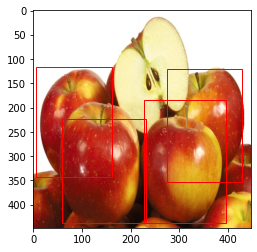

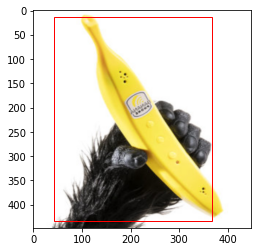

In [30]:
for i in range(20):
  plot_image(val_dataset[i][0].permute(1, 2, 0), targets_after_nms[i])